In [ ]:
import csv
import os
import random
import pickle
import pandas as pd
import numpy as np
from scipy import stats
import datetime
import matplotlib.pyplot as plt
from matplotlib import transforms
import sklearn
import warnings
import seaborn as sns
import matplotlib.patches as mpatches

from nilearn import plotting, datasets
from nilearn.image import load_img, resample_to_img, new_img_like, math_img, coord_transform
from scipy.stats import pearsonr, zscore

import nibabel as nib
import mne
from mne import vertex_to_mni
from nilearn.plotting import plot_connectome

from matplotlib.path import Path
from matplotlib.patches import PathPatch, Circle
from matplotlib.colors import LinearSegmentedColormap

from mne.viz import circular_layout
from mne.datasets import sample
from mne_connectivity.viz import plot_connectivity_circle

In [ ]:
# Get correlations between best DWI modality and predicted g-factor
modality = 'full_correlation_55'
warnings.simplefilter(action='ignore', category=FutureWarning)

############## 1
seed = 42
folds = ["0", "1", "2", "3", "4"]
modality_dfs = {}

features = []
g_pred = []
pls_result = {}

for fold in folds:
    features_corrected = pd.read_csv(f'/PLS/brain/rs/ica_main/fold_{fold}/scaling/{modality}_test_corr_{fold}.csv').drop(columns=['Unnamed: 0'])
    g_pred_test = pd.read_csv(f'/PLS/brain/rs/ica_main/fold_{fold}/g_pred/{modality}_g_pred_test_id_fold_{fold}.csv').drop(columns=['Unnamed: 0', 'eid'])
        
    features.append(features_corrected)
    g_pred.append(g_pred_test)
    
features_five_folds= pd.concat(features, axis=0, ignore_index=True)
g_five_folds= pd.concat(g_pred, axis=0, ignore_index=True)

rs_five_folds_best = pd.concat([g_five_folds['g predicted test'], features_five_folds], axis=1)
rs_five_folds_best.to_csv(f'/PLS/brain/feature_importance/{modality}_five_folds_best.csv')

correlations = []
for feature in features_five_folds.columns:
    r_pred, p_pred = stats.pearsonr(
        g_five_folds.iloc[:, 0].values,  # Ensure 1D array for g_pred
        features_five_folds[feature].values  # Current feature values
        )
    
    correlations.append({
        'feature': feature,
        'corr_with_g_pred': r_pred,  # Single float value
        'p_value_g_pred': p_pred     # Single float value
        })
    
    # Create DataFrame and sort
    modality_df = pd.DataFrame(correlations)
    
output_dir = '/PLS/brain/feature_importance'
output_path = os.path.join(output_dir, f'{modality}_corr_with_g_pred.csv')
modality_df.to_csv(output_path, index=False)

In [ ]:
# Read the files
output_dir = '/PLS/brain/feature_importance'
modality = 'full_correlation_55'
rs_feature_imortance = pd.read_csv(os.path.join(output_dir, f'{modality}_corr_with_g_pred.csv')).copy()

In [6]:
# Map 55 'good' components names
good_55_orig = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 
                22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
                40, 41, 42, 43, 45, 46, 48, 49, 50, 52, 53, 57, 58, 60, 63, 64, 93]

n_components = len(good_55_orig)  # Should be 55

# Generate upper-triangular pairs (column-wise) using ACTUAL component numbers
ic_pairs_upper_columnwise = [
    f"IC{good_55_orig[i]}-IC{good_55_orig[j]}" 
    for j in range(1, n_components)       # Column index (j starts at 1)
    for i in range(j)                     # Row index (i < j)
]

# Verify length (should be 1485 for 55 components)
assert len(ic_pairs_upper_columnwise) == 1485, f"Expected 1485 pairs, got {len(ic_pairs_upper_columnwise)}"

# Example output:
print("First 5 pairs:", ic_pairs_upper_columnwise[:5])  # IC2-IC3, IC2-IC4, IC3-IC4, IC2-IC5, IC3-IC5
print("Last 5 pairs:", ic_pairs_upper_columnwise[-5:])  # IC58-IC93, IC60-IC93, IC63-IC93, IC64-IC93, IC57-IC58

First 5 pairs: ['IC2-IC3', 'IC2-IC4', 'IC3-IC4', 'IC2-IC5', 'IC3-IC5']
Last 5 pairs: ['IC57-IC93', 'IC58-IC93', 'IC60-IC93', 'IC63-IC93', 'IC64-IC93']


In [34]:
# Assign correct column names and get correlation matrix
rs_feature_imortance['feature'] = ic_pairs_upper_columnwise

# Reconstruct full matrix
corr_matrix = np.zeros((n_components, n_components))
pval_matrix = np.zeros((n_components, n_components))
component_to_index = {comp: idx for idx, comp in enumerate(good_55_orig)}


for idx, row in rs_feature_imortance.iterrows():
    i_str, j_str = row['feature'].replace('IC', '').split('-')
    i = component_to_index[int(i_str)]
    j = component_to_index[int(j_str)]
    corr_matrix[i, j] = row['corr_with_g_pred']
    pval_matrix[i, j] = row['p_value_g_pred']

# Mirror to lower triangle (make symmetric)
corr_matrix = corr_matrix + corr_matrix.T
pval_matrix = pval_matrix + pval_matrix.T

# Set diagonal (optional: 0 for feature importance, 1 for correlations)
np.fill_diagonal(corr_matrix, 1)  # or np.fill_diagonal(corr_matrix, 1) if diagonal matters

In [40]:
corr_matrix_fe = corr_matrix.copy()
pval_matrix_fe = pval_matrix.copy()

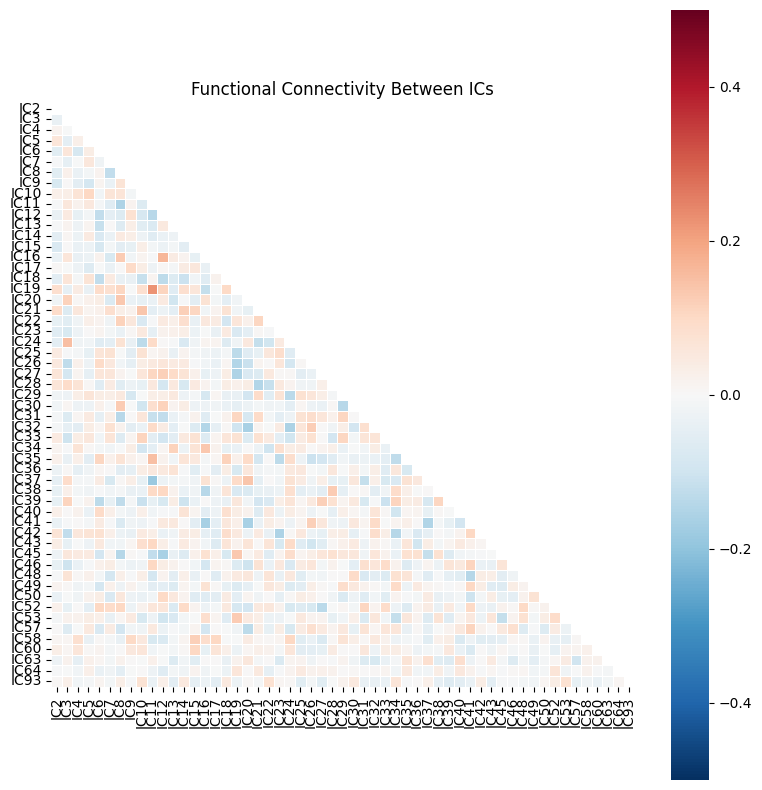

In [ ]:
# Plot heatmap
# Create a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Create the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='RdBu_r',
    center=0,
    square=True,
    xticklabels=node_names,
    yticklabels=node_names,
    vmin=-0.5,
    vmax=0.5,
    linewidths=0.5
)

plt.title('Functional Connectivity Between ICs')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# UK Biobank's example of reconstructing a square matrix from a vector
D = 4
vector_from_file = np.array([1, 2, 3, 4, 5, 6])  # Their flattened data

# Reconstruct matrix
square_net = np.zeros((D, D))
square_net[np.triu_indices(D, k=1)] = vector_from_file  # Fill upper triangle (column-wise)
square_net = square_net + square_net.T  # Mirror to lower triangle

print("Reconstructed matrix:\n", square_net)

Reconstructed matrix:
 [[0. 1. 2. 3.]
 [1. 0. 4. 5.]
 [2. 4. 0. 6.]
 [3. 5. 6. 0.]]


In [ ]:
# 1 Upload dataframe with correlations
modality = 'full_correlation_55'
output_dir = '/PLS/brain/feature_importance'
corr_with_g_pred = pd.read_csv(os.path.join(output_dir, f'{modality}_corr_with_g_pred.csv'))
fcorr_orig = pd.read_csv('/Resting_State/rsfMRI_matrices/full_corr_tables/55/fcorr_55_instance_2_FINAL.csv').drop(columns='ID')
full_correlation_55 = fcorr_orig.copy()
full_correlation_55.columns = ic_pairs_upper_columnwise

In [ ]:
# 2 Reconstruct correlation matrices for each subject
good_55_orig = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 
                22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
                40, 41, 42, 43, 45, 46, 48, 49, 50, 52, 53, 57, 58, 60, 63, 64, 93]

n_components = len(good_55_orig)  # 55
corr_matrix = np.zeros((n_components, n_components))

# Create a mapping from IC number to matrix index
ic_to_index = {ic: idx for idx, ic in enumerate(good_55_orig)}

# Fill the upper triangle
for edge_name in full_correlation_55.columns:  # Columns like "IC2-IC3"
    ic1, ic2 = map(int, [edge_name.split('-')[0][2:], edge_name.split('-')[1][2:]])  # Extract numbers (e.g., "IC2-IC3" → 2, 3)
    i = ic_to_index[ic1]
    j = ic_to_index[ic2]
    corr_matrix[i, j] = full_correlation_55[edge_name].mean()  # Use mean across participants

# Make symmetric and set diagonal to 1
corr_matrix = corr_matrix + corr_matrix.T
np.fill_diagonal(corr_matrix, 1)

## Yeo 7 networks

#### Sequential order of ICs (i.e., 1 to 55 instead of real good ICs numbers)

In [86]:
# Matrix to array: corr
upper_triangle = np.triu_indices_from(corr_matrix_df, k=1)

# Get the values from the upper triangle
values = corr_matrix_df.values[upper_triangle]

# Get the row and column names for the upper triangle
row_names = corr_matrix_df.index[upper_triangle[0]]
col_names = corr_matrix_df.columns[upper_triangle[1]]

# Create the paired names (e.g., "IC1_IC2")
pair_names = [f"{row}-{col}" for row, col in zip(row_names, col_names)]

# Create a DataFrame with the pairs and values
flattened_df = pd.DataFrame({
    'IC_pair': pair_names,
    'correlation': values
})

# Matrix to array: pval
upper_triangle = np.triu_indices_from(pval_matrix_df, k=1)

# Get the values from the upper triangle
values = pval_matrix_df.values[upper_triangle]

# Get the row and column names for the upper triangle
row_names = pval_matrix_df.index[upper_triangle[0]]
col_names = pval_matrix_df.columns[upper_triangle[1]]

# Create the paired names (e.g., "IC1_IC2")
pair_names = [f"{row}-{col}" for row, col in zip(row_names, col_names)]

# Create a DataFrame with the pairs and values
flattened_df_pval = pd.DataFrame({
    'IC_pair': pair_names,
    'pval': values
})

Prepare data for plotting

In [ ]:
# 1. Load UKB's 100-component ICA maps
ukb_ica = load_img("/feature-imp/rs/UKBiobank_BrainImaging_GroupMeanTemplates/rfMRI_ICA_d100.nii.gz")
ica_data = ukb_ica.get_fdata()
good_55 = np.loadtxt("/feature-imp/rs/UKBiobank_BrainImaging_GroupMeanTemplates/rfMRI_GoodComponents_d100_v1.txt", dtype=str)

# 2. Load Yeo 7-network atlas
from nilearn.datasets import fetch_atlas_yeo_2011
yeo = fetch_atlas_yeo_2011()
yeo_7 = yeo['thick_7']  # 7-network volumetric atlas
yeo_7_labels = [
    'Visual', 
    'Somatomotor', 
    'Dorsal Attention',
    'Ventral Attention', 
    'Limbic',
    'Frontoparietal', 
    'Default Mode'
]

# 3. Resample Yeo atlas to match UKB ICA space
yeo_7_resampled = resample_to_img(yeo_7, ukb_ica, interpolation='nearest')

# Assign each IC to the best-matching network
ic_assignments = []
for ic in good_55_orig:
    # Get IC data (3D array)
    ic_data = ukb_ica.slicer[..., ic-1].get_fdata()
    yeo_mask = yeo_7_resampled.get_fdata()  # 3D network mask
    
    # Flatten both arrays for indexing
    ic_flat = ic_data.flatten()
    yeo_flat = yeo_mask.flatten()
    
    # Only use voxels belonging to any network (yeo_flat > 0)
    mask = yeo_flat > 0
    ic_network_voxels = ic_flat[mask]
    
    # Normalize the IC values within network voxels
    ic_norm = zscore(ic_network_voxels)
    
    correlations = []
    for net_val in range(1, 8):  # Yeo networks 1-7
        net_mask = (yeo_flat[mask] == net_val)
        if net_mask.sum() > 100:  # Minimum voxel threshold
            mean_activation = np.mean(ic_norm[net_mask])
            correlations.append((net_val, mean_activation))
    
    if correlations:
        best_net, best_activation = max(correlations, key=lambda x: abs(x[1]))
        ic_assignments.append({
            'IC': f"IC{ic}",
            'Network': yeo_7_labels[best_net-1],
            'Activation': best_activation
        })

assignments_df = pd.DataFrame(ic_assignments)
output_dir = '/feature-imp/rs'
output_path = os.path.join(output_dir, f'{modality}_ic-network-assign.csv')
assignments_df.to_csv(output_path, index=False)   

#assignments_df = pd.read_csv(output_path)
# 4. Set of network colours for Yeo parcellation
network_colors = {
    'Visual':  '#ffa500',
    'Somatomotor': '#4b0082',
    'Dorsal Attention': '#4682B4',
    'Ventral Attention':  '#00ced1' ,
    'Limbic': '#8b4513',
    'Frontoparietal': '#ff0000',
    'Default Mode': '#2f4f4f',
}


# 5. Create a mapping from original IC numbers to sequential 1-55
sequential_names = {f"IC{orig}": f"IC{seq+1}" for seq, orig in enumerate(good_55_orig)}

# 6. Apply to assignments DataFrame
yeo_assign = assignments_df.copy()
yeo_assign['IC_sequential'] = yeo_assign['IC'].map(sequential_names)

network_order = list(network_colors.keys())

# 7. Prepare node properties with sequential names
node_names = [sequential_names[f"IC{comp}"] for comp in good_55_orig]  # Now IC1-IC55
node_colors = [network_colors[yeo_assign.loc[yeo_assign['IC'] == f"IC{comp}", 'Network'].values[0]] 
              for comp in good_55_orig]

# 8. Sort nodes by network (using original DF)
network_labels = [network_order.index(yeo_assign.loc[yeo_assign['IC'] == f"IC{comp}", 'Network'].values[0])
                 for comp in good_55_orig]
sort_idx = np.argsort(network_labels)

# 9. Apply sorting
sorted_node_names = [node_names[i] for i in sort_idx]
sorted_node_colors = [node_colors[i] for i in sort_idx]

# 10. Verify mapping
print(yeo_assign[['IC', 'IC_sequential', 'Network']].head())

    IC IC_sequential            Network
0  IC2           IC1             Visual
1  IC3           IC2  Ventral Attention
2  IC4           IC3             Visual
3  IC5           IC4             Visual
4  IC6           IC5       Default Mode


In [ ]:
yeo_assign

,IC,Network,Activation,IC_sequential
0,IC2,Visual,0.922145,IC1
1,IC3,Ventral Attention,1.395882,IC2
2,IC4,Visual,1.017552,IC3
3,IC5,Visual,0.447842,IC4
4,IC6,Default Mode,0.638662,IC5
5,IC7,Somatomotor,0.739368,IC6
6,IC8,Default Mode,0.619435,IC7
7,IC9,Visual,0.475548,IC8
8,IC10,Default Mode,0.487923,IC9
9,IC11,Limbic,-0.203607,IC10


In [ ]:
# Sort feature importance matrices
# For original correlations
sorted_corr_matrix = corr_matrix[sort_idx][:, sort_idx]

# For feature importance (it is a copy of corr_matrix)
sorted_importance_matrix = corr_matrix_fe[sort_idx][:, sort_idx]
sorted_pval_matrix = pval_matrix_fe[sort_idx][:, sort_idx]
sig_mask = (sorted_pval_matrix < 0.05) & (np.abs(sorted_importance_matrix) > 0.0)
thresholded_matrix = sorted_importance_matrix * sig_mask

In [ ]:
# Define corr and pval matrices
corr_matrix_df = pd.DataFrame(corr_matrix, columns = yeo_assign['IC_sequential'], index = yeo_assign['IC_sequential'])
pval_matrix_df = pd.DataFrame(pval_matrix, columns = yeo_assign['IC_sequential'], index = yeo_assign['IC_sequential'])

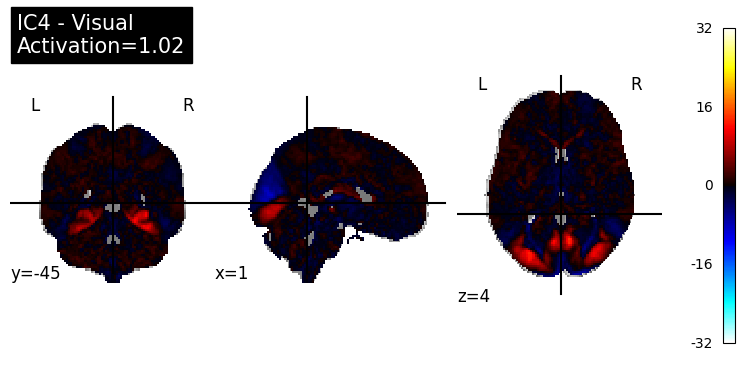

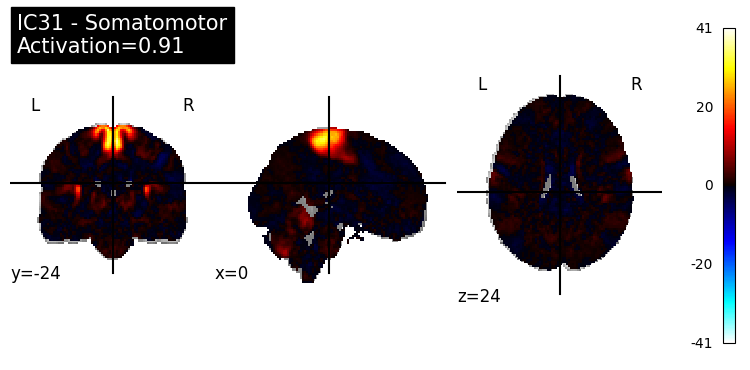

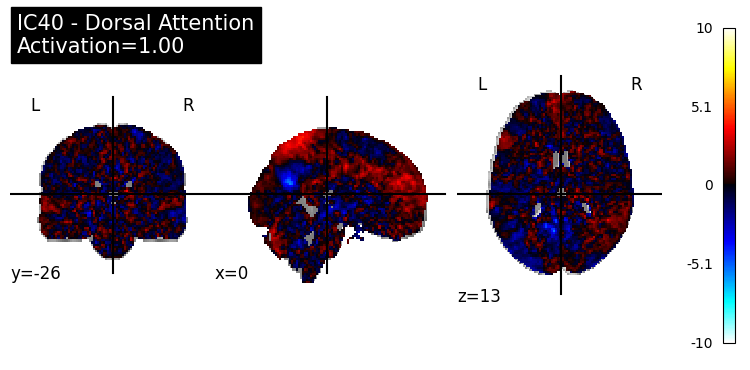

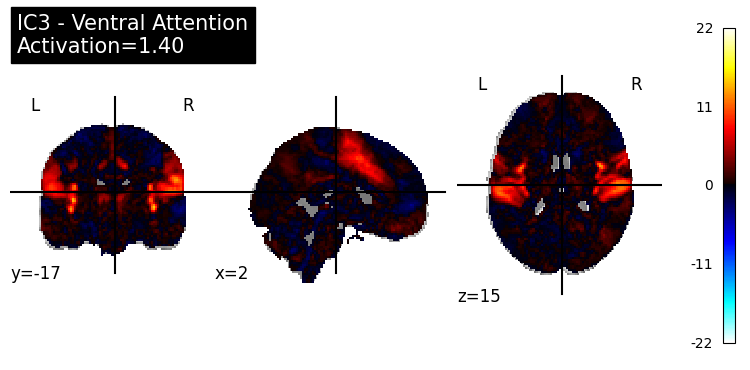

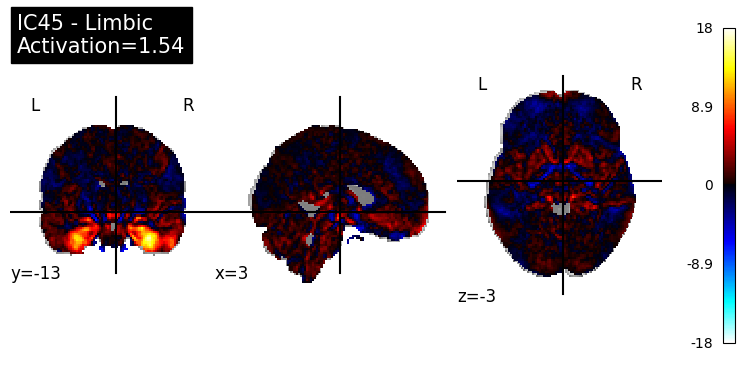

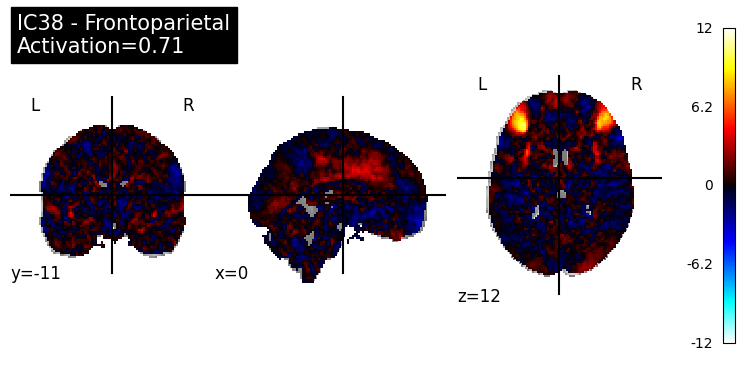

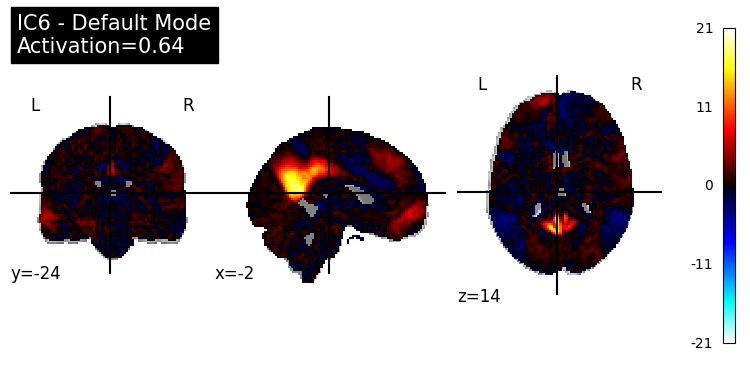

In [ ]:
# Plot strongest component for each network
for network in yeo_7_labels:
    net_df = yeo_assign[yeo_assign['Network'] == network]
    if not net_df.empty:
        best_ic = net_df.loc[net_df['Activation'].abs().idxmax()]
        plotting.plot_stat_map(
            ukb_ica.slicer[..., int(best_ic['IC'][2:])-1],
            title=f"{best_ic['IC']} - {network}\nActivation={best_ic['Activation']:.2f}",
            #cut_coords=8
        )
plt.show()

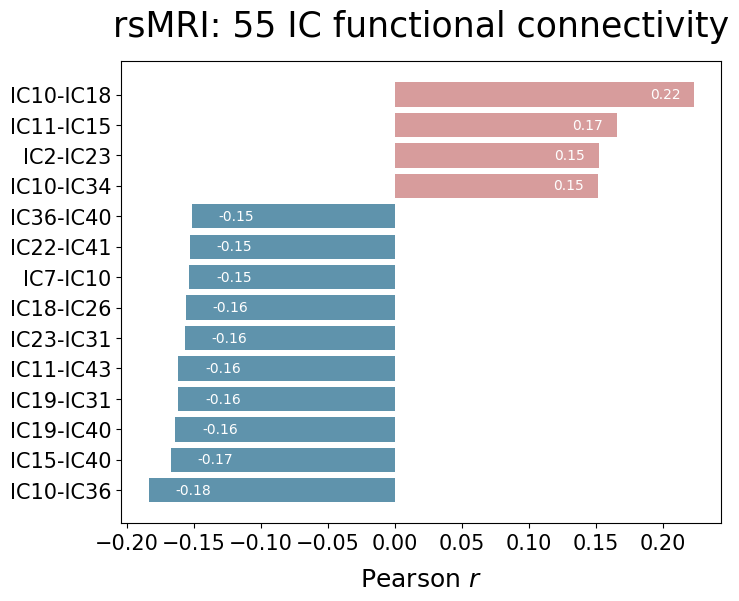

In [ ]:
# Barplot r>0.15
feature_imp_ic_df = pd.concat([flattened_df, flattened_df_pval.drop(columns='IC_pair')], axis=1)
feature_imp_ic_df_filtered = feature_imp_ic_df[
    (feature_imp_ic_df['pval'] < 0.05) & 
    (feature_imp_ic_df['correlation'].abs() > 0.15)]

# Filter for significant correlations (p < 0.05) and absolute correlation > 0.2
plot_df_filtered = feature_imp_ic_df_filtered.copy()

# Sort the filtered data
ordered = (plot_df_filtered
         .assign(abs_corr = plot_df_filtered['correlation'].abs())
         .sort_values('abs_corr', ascending=False)
         ).sort_values('correlation', ascending=False)

# Create the figure - adjust size based on number of features
n_bars = len(ordered)
plt.figure(figsize=(10, max(6, n_bars * 0.2)), dpi=100)  # Increased height multiplier

# Create color list - blue for positive, red for negative
colors = ['#D79C9CFF' if x > 0 else '#5F93ACFF' for x in ordered['correlation']]

# Create horizontal bars using connection names
bars = plt.barh(ordered['IC_pair'],  # Using the connection names now
                ordered['correlation'], 
                color=colors,
                #alpha=0.7,
                height=0.8)  # Increased bar thickness

# Add correlation values on bars
for bar, corr in zip(bars, ordered['correlation']):
    width = bar.get_width()
    label_x = width - 0.01 if width > 0 else width + 0.02
    plt.text(label_x, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}',
             va='center', ha='right' if width > 0 else 'left',
             color='white', fontsize=10)

# Formatting
plt.title('rsMRI: 55 IC functional connectivity', 
          pad=18, fontsize=25)
plt.xlabel('Pearson $r$', labelpad=10, fontsize=18)
plt.xticks(fontsize=15)
plt.ylabel('')
plt.yticks(fontsize=15)
plt.gca().invert_yaxis()  # Highest values at top

# Adjust layout with more space for long labels
#plt.tight_layout()
plt.subplots_adjust(left=0.3)  # Add more space on left for long labels

fig_path = '/feature-imp/figures/supplem'
plt.savefig(os.path.join(fig_path, 'fi-rsmri-BARS.png'), 
            dpi=350,  # Increased from 300 to 350
            bbox_inches='tight')

plt.show()

In [ ]:
# Define figure path
fig_path = '/feature-imp/figures'

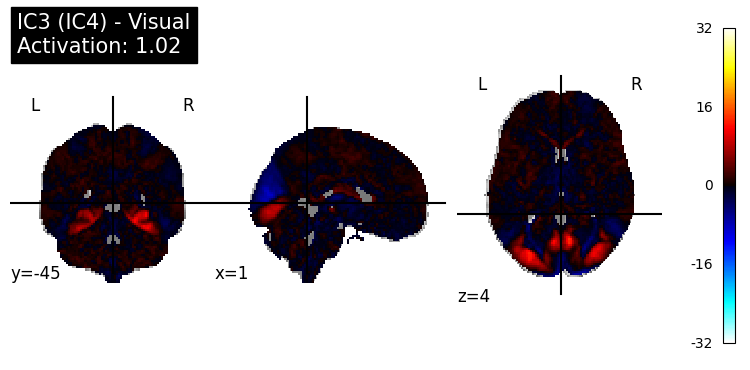

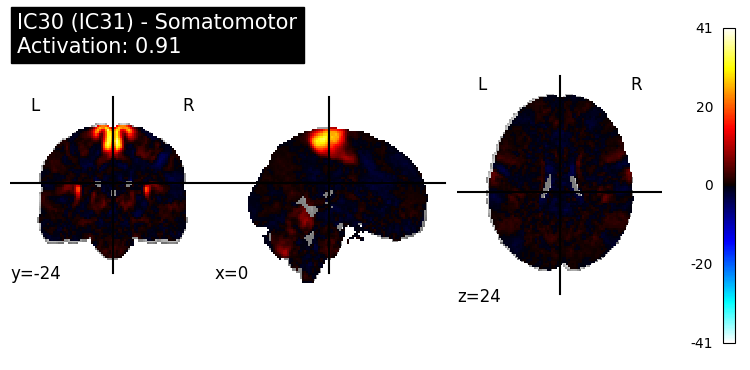

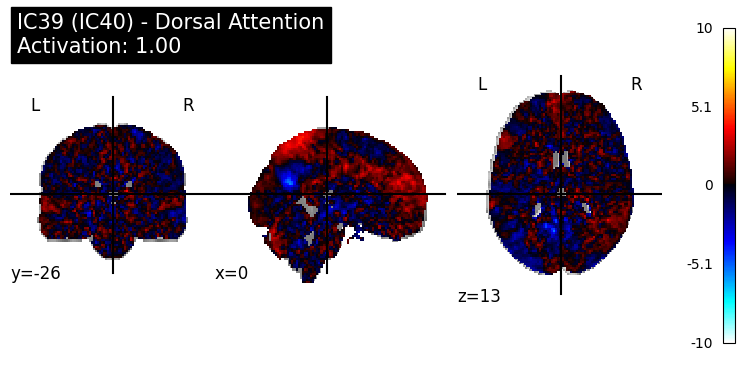

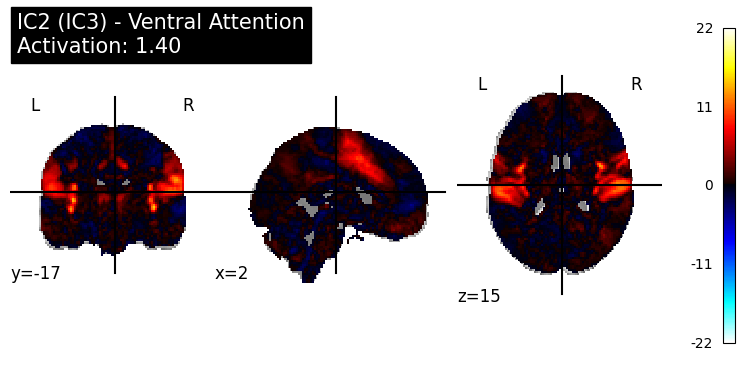

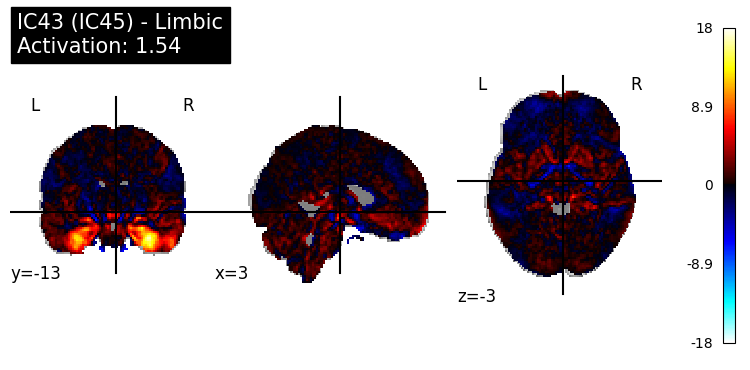

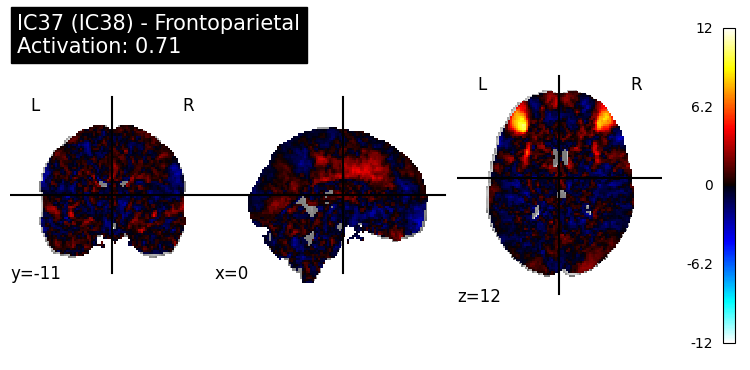

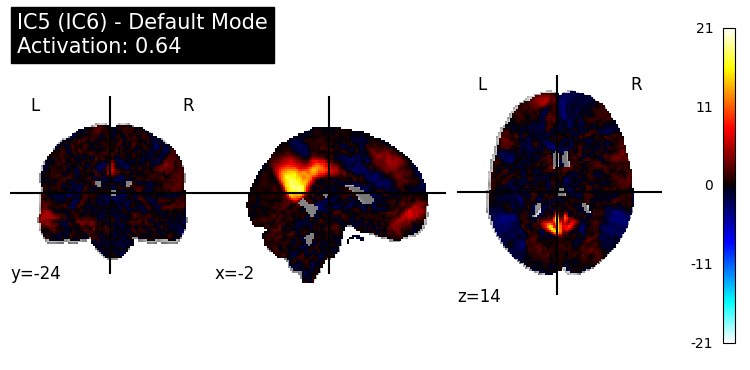

In [93]:
# Plot strongest component for each network (using sequential numbering)
for network in yeo_7_labels:
    net_df = yeo_assign[yeo_assign['Network'] == network]
    if not net_df.empty:
        best_ic = net_df.loc[net_df['Activation'].abs().idxmax()]
        
        # Get the original and sequential names
        orig_ic_name = best_ic['IC']  # e.g., "IC2"
        seq_ic_name = best_ic['IC_sequential']  # e.g., "IC1"
        
        # Extract original IC number (0-based index for nilearn)
        orig_ic_num = int(orig_ic_name[2:])  # extracts 2 from "IC2"
        
        plotting.plot_stat_map(
            ukb_ica.slicer[..., orig_ic_num-1],  # Original ICA component
            title=f"{seq_ic_name} ({orig_ic_name}) - {network}\nActivation: {best_ic['Activation']:.2f}",
            #cut_coords=8,
            display_mode='ortho',
            colorbar=True,
            cmap='cold_hot'
        )
plt.show()

### Connectogram

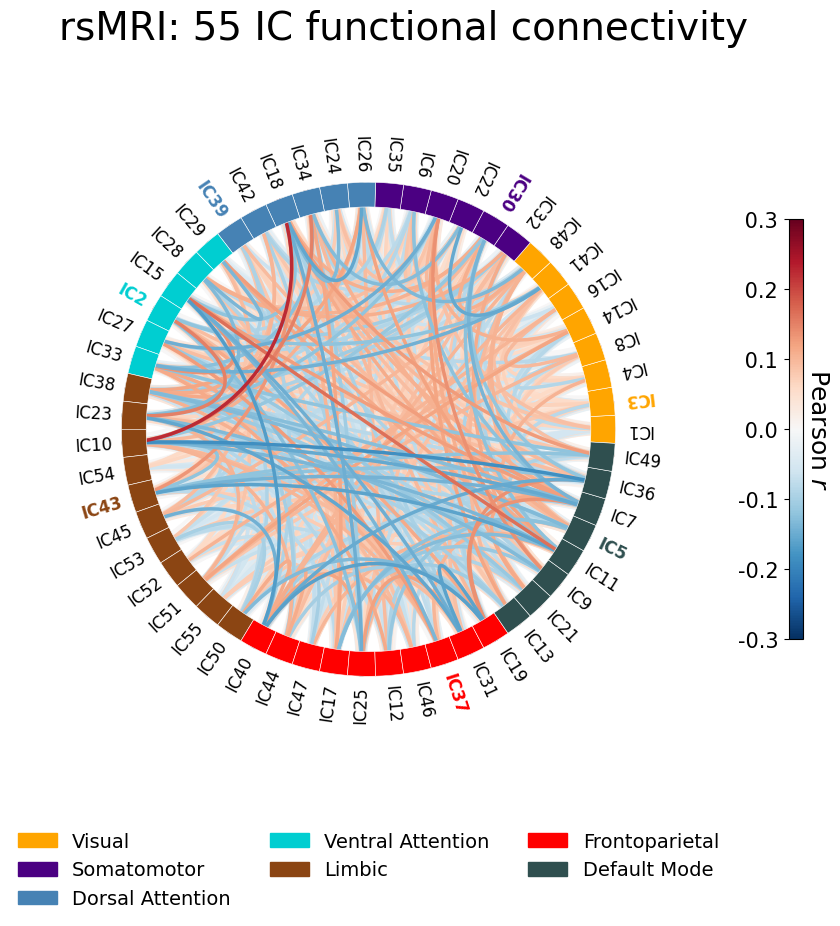

In [43]:
plt.close('all')
fig = plt.figure(figsize=(7, 7), facecolor='white', constrained_layout=True)

# Create a dictionary for label colors
label_colors = {
    'IC5': '#2f4f4f',
    'IC37': '#ff0000',
    'IC43': '#8b4513',
    'IC2': '#00ced1',
    'IC30': '#4b0082',
    'IC3': '#ffa500',
    'IC39': '#4682B4'
}

# Calculate symmetric vmin/vmax
max_val = np.max(np.abs(sorted_importance_matrix))
vmin, vmax = -max_val, max_val

# Create plot WITHOUT built-in colorbar
display = plot_connectivity_circle(
    thresholded_matrix,
    node_names=sorted_node_names,
    node_colors=sorted_node_colors,
    facecolor='white',
    textcolor='black',  # Default color, we'll modify specific labels after
    colormap='RdBu_r',
    vmin=-0.3,
    vmax=0.3,
    colorbar=False,
    linewidth=2.5,
    node_edgecolor='white',
    node_linewidth=0.4,
    fontsize_names=12,
    padding=4.0,
    fig=fig,
    subplot=111,
    show=False
)

# Modify label colors for specific ICs
# Get all text objects in the figure
for ax in fig.axes:
    for text in ax.texts:
        txt = text.get_text()
        if txt in label_colors:
            text.set_color(label_colors[txt])
            # Optional: make the text bold
            text.set_fontweight('bold')

# Add custom colorbar
cax = fig.add_axes([1.1, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-0.3, vmax=0.3))
sm.set_array([])  # Empty array for the ScalarMappable
cbar = fig.colorbar(sm, cax=cax)

# Customize colorbar
cbar.set_label('Pearson $r$', rotation=270, labelpad=20, fontsize=18)

# Adjust tick parameters for compact, Nilearn-like appearance
cbar.ax.tick_params(
    labelsize=15,
    pad=-50,
    right=False,
    left=True
)

# Special formatting for minus sign
cbar.ax.yaxis.set_major_formatter(plt.FormatStrFormatter('% .1f'))

# For even more Nilearn-like minus signs (narrower):
from matplotlib import rcParams
rcParams['axes.unicode_minus'] = False

# Add legend
legend_patches = [mpatches.Patch(color=color, label=f"{net}") 
                 for net, color in network_colors.items()]

fig.legend(
    handles=legend_patches,
    bbox_to_anchor=(0.5, -0.05),
    loc='upper center',
    frameon=True,
    fontsize=14,
    edgecolor='white',
    ncol=3
)

# Title
fig.suptitle(
    "rsMRI: 55 IC functional connectivity\n",
    y=1.1,x=0.55,
    fontsize=28,
)
plt.savefig(os.path.join(fig_path, 'fi-rs.png'), dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

### rsMRI maps for supplem

<Figure size 800x600 with 0 Axes>

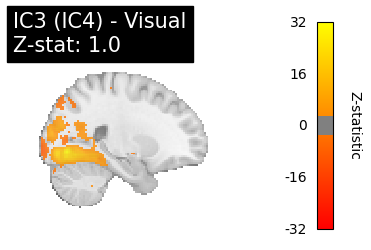

<Figure size 800x600 with 0 Axes>

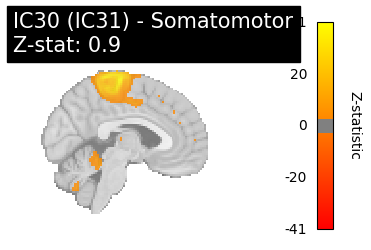

<Figure size 800x600 with 0 Axes>

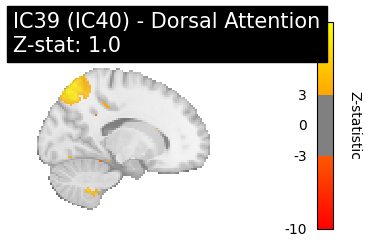

<Figure size 800x600 with 0 Axes>

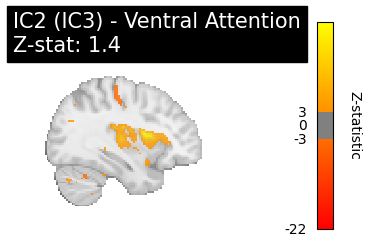

<Figure size 800x600 with 0 Axes>

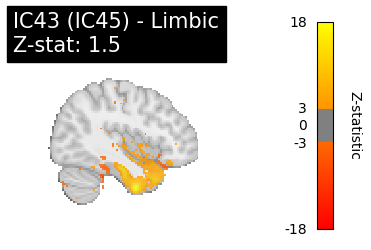

<Figure size 800x600 with 0 Axes>

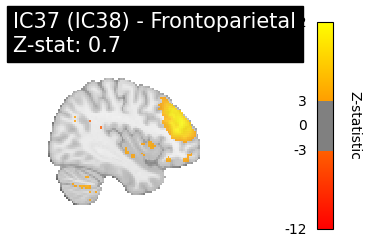

<Figure size 800x600 with 0 Axes>

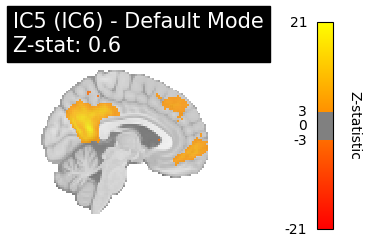

In [ ]:
# Define UK Biobank-style plotting parameters
ukb_style = {
    'display_mode': 'x',  # Single axial slice 'z'
    'cut_coords': 1,      # Just one slice
    'cmap': 'autumn',     # Yellowish FSL-like colormap
    'colorbar': True,
    'threshold': 3.0,     # Typical FSL threshold
    'black_bg': False,    # White background
    'alpha': 0.8,         # Slightly transparent
    'annotate': False     # No anatomical labels
}

# Plot strongest component for each network
for network in yeo_7_labels:
    net_df = yeo_assign[yeo_assign['Network'] == network]
    if not net_df.empty:
        best_ic = net_df.loc[net_df['Activation'].abs().idxmax()]
        orig_ic_num = int(best_ic['IC'][2:])  # extracts 2 from "IC2"
        
        # Create figure with tight layout
        plt.figure(figsize=(8, 6))
        
        # UKB-style plot
        display = plotting.plot_stat_map(
            ukb_ica.slicer[..., orig_ic_num-1],
            title=f"{best_ic['IC_sequential']} ({best_ic['IC']}) - {network}\nZ-stat: {best_ic['Activation']:.1f}",
            **ukb_style
        )
        
        # Customize colorbar to match FSL
        if display._cbar:
            display._cbar.set_label('Z-statistic', rotation=270, labelpad=20)
            display._cbar.ax.tick_params(labelsize=10)
        
        #plt.tight_layout()
        plt.show()

In [ ]:
# Get INDIVIDUAL IC activation images
view = 'x'
transparent_style = {
    'display_mode': f'{view}',      # Single axial slice
    'cut_coords': 1,          # Just one slice
    'cmap': 'autumn',         # Yellowish FSL-like colormap
    'colorbar': False,        # No colorbar
    'threshold': 3.0,         # Typical FSL threshold
    'black_bg': False,        # Must be False for transparency
    'alpha': 1.0,             # Full opacity for activations
    'annotate': False,        # No anatomical labels
    'draw_cross': False       # No crosshairs
}

# Plot and save components with transparent background
for network in yeo_7_labels:
    net_df = yeo_assign[yeo_assign['Network'] == network]
    if not net_df.empty:
        best_ic = net_df.loc[net_df['Activation'].abs().idxmax()]
        orig_ic_num = int(best_ic['IC'][2:])
        
        fig = plt.figure(figsize=(8, 6), facecolor='none', dpi=300)  # Transparent figure
        ax = fig.add_subplot(111, facecolor='none')  # Transparent axes
        
        display = plotting.plot_stat_map(
            ukb_ica.slicer[..., orig_ic_num-1],
            axes=ax,
            figure=fig,
            **transparent_style
        )
        
        ax.axis('off')
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
        
        # Save with transparent background
        output_dir = '/feature-imp/rs'
        filename = f"{output_dir}/{best_ic['IC_sequential']}({best_ic['IC']})_transparent-{network}-{view}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0, transparent=True) #facecolor=fig.get_facecolor()
        plt.close()